In [1]:
# !pip install ../input/nfl-lib/timm-0.1.26-py3-none-any.whl
!tar xfz ../input/nfl-lib/pkgs.tgz
# for pytorch1.6
# cmd = "sed -i -e 's/ \/ / \/\/ /' timm-efficientdet-pytorch/effdet/bench.py"
# !$cmd

In [2]:
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
import pandas as pd
import gc
import warnings
import shutil as sh
from tqdm.auto import tqdm
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
d = pd.read_csv('../input/nfl-impact-detection/test_player_tracking.csv')
IS_PRIVATE = d.shape != (19269, 12)
IS_PRIVATE = True
# print(IS_PRIVATE)

# IS_PRIVATE = True

In [4]:
DATA_ROOT_PATH = 'test_images'

In [5]:
def mk_images(video_name, video_labels, video_dir, out_dir, only_with_impact=True):
    video_path=f"{video_dir}/{video_name}"
    video_name = os.path.basename(video_path)
    vidcap = cv2.VideoCapture(video_path)
    if only_with_impact:
        boxes_all = video_labels.query("video == @video_name")
        print(video_path, boxes_all[boxes_all.impact > 1.0].shape[0])
    else:
        print(video_path)
    frame = 0
    while True:
        it_worked, img = vidcap.read()
        if not it_worked:
            break
        frame += 1
        if only_with_impact:
            boxes = video_labels.query("video == @video_name and frame == @frame")
            boxes_with_impact = boxes[boxes.impact > 1.0]
            if boxes_with_impact.shape[0] == 0:
                continue
        img_name = f"{video_name}_frame{frame}"
        image_path = f'{out_dir}/{video_name}'.replace('.mp4',f'_{frame}.png')
        _ = cv2.imwrite(image_path, img)

In [6]:
from math import sqrt
from joblib import Parallel, delayed
from tqdm.auto import tqdm
if IS_PRIVATE:
    out_dir = DATA_ROOT_PATH
    if not os.path.exists(out_dir) or True:
        !mkdir -p $out_dir
        video_dir = '/kaggle/input/nfl-impact-detection/test'
        uniq_video = [path.split('/')[-1] for path in glob(f'{video_dir}/*.mp4')]
        Parallel(n_jobs=4)(delayed(mk_images)(video_name, pd.DataFrame(), video_dir, out_dir, only_with_impact=False) for video_name in tqdm(uniq_video))

#         for video_name in uniq_video:
#             mk_images(video_name, pd.DataFrame(), video_dir, out_dir, only_with_impact=False)

In [7]:
!cp -r ../input/my-yolov5-train/yolov5/* .
# !cp -r ../input/yolov5/utils/* ./utils/

In [8]:
import argparse
from utils.datasets import *
from utils.general import non_max_suppression
from utils.general import *
from utils import torch_utils 
from utils.plots import plot_one_box

In [9]:
from tqdm.auto import tqdm
names = ['0','1','2']
def detect(save_img=False):
    weights, imgsz = opt.weights,opt.img_size
    source = 'test_images/'
    
    # Initialize
    device = torch_utils.select_device(opt.device)
    half = False
    # Load model

    model = torch.load(weights, map_location=device)['model'].to(device).float().eval()

    dataset = LoadImages(source, img_size=opt.img_size)

    t0 = time.time()
    img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
    all_path=[]
    all_bboxex =[]
    all_score =[]
    all_c = []
    for path, img, im0s, vid_cap in tqdm(dataset):
        print(im0s.shape)
#         if path.split("/")[-1]=="57596_002686_Endzone_426.jpg":
#             break
        img = torch.from_numpy(img).to(device)
        img = img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = torch_utils.time_synchronized()
        bboxes_2 = []
        score_2 = []
        c_2 = []
        if True:
            pred = model(img, augment=opt.augment)[0]
            pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=None, agnostic=False)
            t2 = torch_utils.time_synchronized()
            flag=False
            bboxes = []
            score = []
            cc = []
            # Process detections
            for i, det in enumerate(pred):  # detections per image
                p, s, im0 = path, '', im0s
                gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  #  normalization gain whwh
                if det is not None and len(det):
                    det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
                    for c in det[:, -1].unique():
                        n = (det[:, -1] == c).sum()  # detections per class

#                     for *xyxy, conf, cls in reversed(det):
#                         if cls==2:
#                             flag = True
#                             label = '%s %.2f' % (names[int(cls)], conf)
#                             plot_one_box(xyxy, im0, label=label, color=255, line_thickness=3)
#             if flag:
#                 plt.imshow(im0)
#                 plt.show()
                    for *xyxy, conf, cls in det:
#                         if cls==2 or cls=='2':  # Write to file
                            xywh = torch.tensor(xyxy).view(-1).numpy()  # normalized xywh
#                             xywh[2] = xywh[2]-xywh[0]
#                             xywh[3] = xywh[3]-xywh[1]
                            bboxes.append(xywh)
                            score.append(conf.cpu().numpy())
                            cc.append(cls.cpu().numpy())
            bboxes_2.append(bboxes)
            score_2.append(score)
            c_2.append(cc)
        all_path.append(path)
        all_score.append(score_2)
        all_bboxex.append(bboxes_2)
        all_c.append(c_2)
    return all_path,all_score,all_bboxex,all_c


if __name__ == '__main__':
    class opt:
        weights = "../input/yolov5temp1280/best (2).pt"
        img_size = 1280
        conf_thres = 0.1
        iou_thres = 0.3
        augment = False
        device = '0'
        classes=None
        agnostic_nms = True
        
    opt.img_size = check_img_size(opt.img_size)
    print(opt)

    with torch.no_grad():
        res = detect()

<class '__main__.opt'>


image 1/2664 /kaggle/working/test_images/57906_000718_Endzone_1.png: (720, 1280, 3)
image 2/2664 /kaggle/working/test_images/57906_000718_Endzone_10.png: (720, 1280, 3)
image 3/2664 /kaggle/working/test_images/57906_000718_Endzone_100.png: (720, 1280, 3)
image 4/2664 /kaggle/working/test_images/57906_000718_Endzone_101.png: (720, 1280, 3)
image 5/2664 /kaggle/working/test_images/57906_000718_Endzone_102.png: (720, 1280, 3)
image 6/2664 /kaggle/working/test_images/57906_000718_Endzone_103.png: (720, 1280, 3)
image 7/2664 /kaggle/working/test_images/57906_000718_Endzone_104.png: (720, 1280, 3)
image 8/2664 /kaggle/working/test_images/57906_000718_Endzone_105.png: (720, 1280, 3)
image 9/2664 /kaggle/working/test_images/57906_000718_Endzone_106.png: (720, 1280, 3)
image 10/2664 /kaggle/working/test_images/57906_000718_Endzone_107.png: (720, 1280, 3)
image 11/2664 /kaggle/working/test_images/57906_000718_Endzone_108.png: (720, 1280, 3)
image 12/2664 /kaggle/working/test_images/57906_000718_

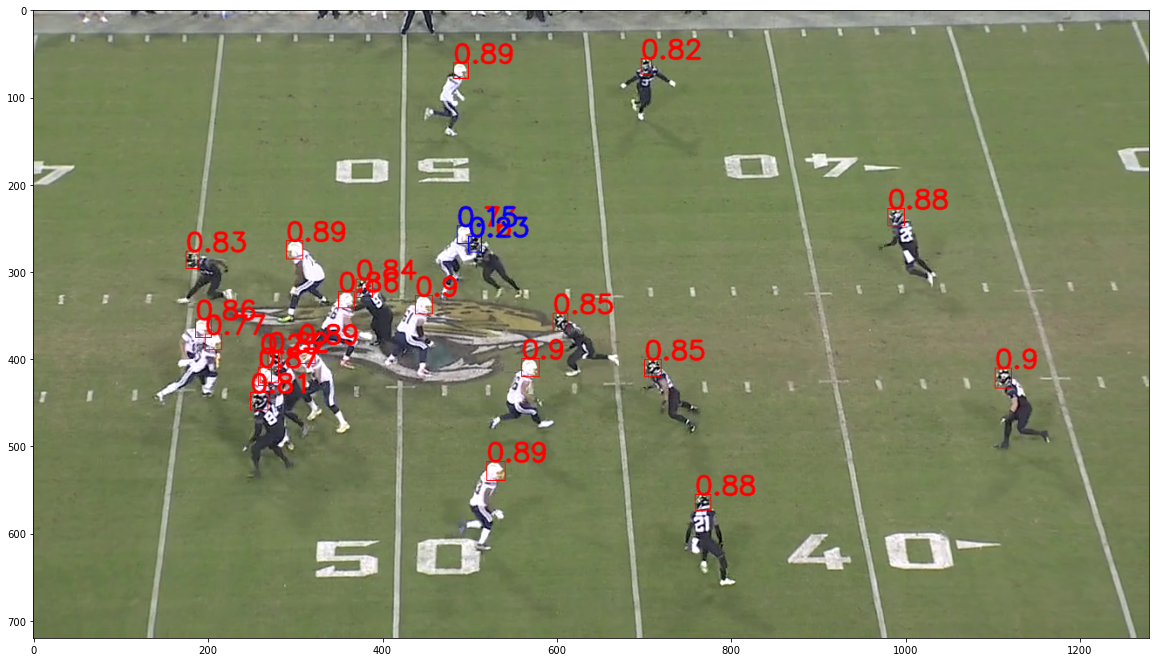

In [10]:
%matplotlib inline
all_path,all_score,all_bboxex,all_labels = res

results =[]
results_boxes =[]
results_scores = []
results_labels = []
result_image_ids =[]
for row in range(len(all_path)):
    image_id = all_path[row].split("/")[-1]
    boxes = np.array(all_bboxex[row])[0]
    scores = np.array(all_score[row])[0]
    labels = np.array(all_labels[row])[0]
    if len(boxes)==0:
        continue
    boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    boxes = boxes.astype(int)
    if len(boxes)>0:
        result_image_ids += [image_id]*len(boxes)
        results_boxes.append(boxes)
        results_scores.append(scores)
        results_labels.append(labels)
        idx = row
        

idx = 0
size = 300
idx =-1
font = cv2.FONT_HERSHEY_SIMPLEX 
image = image = cv2.imread(all_path[idx], cv2.IMREAD_COLOR)
# fontScale 
fontScale = 1
boxes = results_boxes[idx]
scores = results_scores[idx]
label = results_labels[idx]
# Blue color in BGR 
color = (255, 0, 0) 

# Line thickness of 2 px 
thickness = 2
for b,s,l in zip(boxes,scores,label):
    color = (255,0,0) if int(l)==2 else (0,0,255)
    image = cv2.rectangle(image, (b[0],b[1]), (b[0]+b[2],b[1]+b[3]), color, 1) 
    image = cv2.putText(image, '{:.2}'.format(s), (int(b[0]),int(b[1])), font,  fontScale, color, thickness, cv2.LINE_AA)
plt.figure(figsize=[20,20])
plt.imshow(image[:,:,::-1])
plt.show()

In [11]:
box_df = pd.DataFrame(np.concatenate(results_boxes), columns=['left', 'top', 'width', 'height'])
score_df = pd.DataFrame({'scores':np.concatenate(results_scores),'labels':np.concatenate(results_labels), 'image_name':result_image_ids})
test_df = pd.concat([box_df, score_df], axis=1)

In [12]:
test_df.head()

,left,top,width,height,scores,labels,image_name
0,356,170,19,27,0.896919,1.0,57906_000718_Endzone_1.png
1,802,178,18,28,0.894049,1.0,57906_000718_Endzone_1.png
2,614,164,19,28,0.879264,1.0,57906_000718_Endzone_1.png
3,673,414,20,19,0.875360,1.0,57906_000718_Endzone_1.png
4,129,215,24,27,0.873769,1.0,57906_000718_Endzone_1.png


In [13]:
#gameKey,playID,view,video,frame,left,width,top,height
#57590,3607,Endzone,57590_003607_Endzone.mp4,1,1,1,1,1
test_df['gameKey'] = test_df.image_name.str.split('_').str[0].astype(int)
test_df['playID'] = test_df.image_name.str.split('_').str[1].astype(int)
test_df['view'] = test_df.image_name.str.split('_').str[2]
test_df['frame'] = test_df.image_name.str.split('_').str[3].str.replace('.png','').astype(int)
test_df['video'] = test_df.image_name.str.rsplit('_',1).str[0] + '.mp4'
# test_df = test_df[["gameKey","playID","view","video","frame","left","width","top","height"]]

In [14]:
test_df.head()

,left,top,width,height,scores,labels,image_name,gameKey,playID,view,frame,video
0,356,170,19,27,0.896919,1.0,57906_000718_Endzone_1.png,57906,718,Endzone,1,57906_000718_Endzone.mp4
1,802,178,18,28,0.894049,1.0,57906_000718_Endzone_1.png,57906,718,Endzone,1,57906_000718_Endzone.mp4
2,614,164,19,28,0.879264,1.0,57906_000718_Endzone_1.png,57906,718,Endzone,1,57906_000718_Endzone.mp4
3,673,414,20,19,0.875360,1.0,57906_000718_Endzone_1.png,57906,718,Endzone,1,57906_000718_Endzone.mp4
4,129,215,24,27,0.873769,1.0,57906_000718_Endzone_1.png,57906,718,Endzone,1,57906_000718_Endzone.mp4


In [15]:
# clearing working dir
# be careful when running this code on local environment!
# !rm -rf *
!mv * /tmp/

In [16]:
test_df.to_csv('off.csv',index=False)

In [17]:
test_df.shape

(58433, 12)

In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from scipy.optimize import linear_sum_assignment

In [19]:
SEED = 42
FOLDS = 5
FOLD = 2
EFF_DET = 5 
Threshold = 0.45
LOOK_BACKWARD_LIMIT = 10
IOU_THRESHOLD = 0.4
IMAGE_SIZE = 512
NUM_CLASSES = 2
BATCH_SIZE = 16
FRAME_THRESHOLD = 120
keep_columns_threshold = 20

In [20]:
def iou(bbox1, bbox2):
    bbox1 = [float(x) for x in bbox1]
    bbox2 = [float(x) for x in bbox2]

    (x0_1, y0_1, x1_1, y1_1) = bbox1
    (x0_2, y0_2, x1_2, y1_2) = bbox2

    # get the overlap rectangle
    overlap_x0 = max(x0_1, x0_2)
    overlap_y0 = max(y0_1, y0_2)
    overlap_x1 = min(x1_1, x1_2)
    overlap_y1 = min(y1_1, y1_2)

    # check if there is an overlap
    if overlap_x1 - overlap_x0 <= 0 or overlap_y1 - overlap_y0 <= 0:
            return 0

    # if yes, calculate the ratio of the overlap to each ROI size and the unified size
    size_1 = (x1_1 - x0_1) * (y1_1 - y0_1)
    size_2 = (x1_2 - x0_2) * (y1_2 - y0_2)
    size_intersection = (overlap_x1 - overlap_x0) * (overlap_y1 - overlap_y0)
    size_union = size_1 + size_2 - size_intersection

    return size_intersection / size_union

def precision_calc(gt_boxes, pred_boxes):
    cost_matix = np.ones((len(gt_boxes), len(pred_boxes)))
    for i, box1 in enumerate(gt_boxes):
        for j, box2 in enumerate(pred_boxes):
            dist = abs(box1[0]-box2[0])
            if dist > 4:
                continue
            iou_score = iou(box1[1:], box2[1:])

            if iou_score < 0.35:
                continue
            else:
                cost_matix[i,j]=0
    row_ind, col_ind = linear_sum_assignment(cost_matix)
    fn = len(gt_boxes) - row_ind.shape[0]
    fp = len(pred_boxes) - col_ind.shape[0]
    tp=0
    for i, j in zip(row_ind, col_ind):
        if cost_matix[i,j]==0:
            tp+=1
        else:
            fp+=1
            fn+=1
    return tp, fp, fn

In [21]:
def filter_duplicates_and_threshols(row):
    # Compute intersection over union
    boxes,scores,labels = row.box_predictions,row.score_list,row.label_list
    filtered_boxes = []
    filtered_scores = []
    filtered_labels = []
    for box,score,label in zip(boxes,scores,labels):
        # Assume score_list is sorted
        if score> Threshold:
            add_box = True
            for i,ref_box in enumerate(filtered_boxes):
                if iou(box,ref_box)>0.5:
                    add_box = False
                    if label==2:filtered_labels[i]=2

            if add_box: 
                filtered_boxes.append(box)
                filtered_scores.append(score)
                filtered_labels.append(label)
    row.box_predictions,row.score_list,row.label_list = filtered_boxes,filtered_scores,filtered_labels
    return row

def filter_duplicates_and_low_scores(row):
    # Compute intersection over union
    boxes,scores,labels = row.box_predictions,row.score_list,row.label_list
    ordered_sample_predictions = sorted(list(zip(boxes,scores,labels)), key = lambda x:x[1],
                                        reverse = True)
    filtered_boxes = []
    filtered_scores = []
    filtered_labels = []
    for box,score,label in ordered_sample_predictions:
        
        if score>Threshold:
            # Assume score_list is sorted
            add_box = True

            for i,ref_box in enumerate(filtered_boxes):
                if iou(box,ref_box)>0.5:
                    add_box = False
                    if label==2:filtered_labels[i]=2

            if add_box: 
                filtered_boxes.append(box)
                filtered_scores.append(score)
                filtered_labels.append(label)
    row.box_predictions,row.score_list,row.label_list = filtered_boxes,filtered_scores,filtered_labels
    return row

In [22]:
video_labels = pd.read_csv('off.csv')

In [23]:
video_labels = video_labels.sort_values(by=['video','frame']).reset_index(drop=True)
video_labels = video_labels[video_labels.frame>0]
video_labels['image'] = video_labels['video'].str.replace('.mp4', '') + '_' + video_labels['frame'].astype(str) + '.png'
video_labels['right'] = video_labels['left'] + video_labels['width']
video_labels['bottom'] = video_labels['top'] + video_labels['height']
video_labels['label_list'] = video_labels['labels'].apply(lambda x:[x])
video_labels['bbox'] = pd.Series(video_labels[['left','top','right','bottom']].values.tolist(), index=video_labels.index)
video_labels['box_predictions'] = video_labels['bbox'].apply(lambda x:[x])
video_labels['score_list'] = video_labels['scores'].apply(lambda x:[x])
base_cols = ['video','image','gameKey','frame']
target_cols = ['box_predictions','label_list','score_list']
predictions = video_labels[base_cols+target_cols].groupby(base_cols).sum().reset_index()
predictions = predictions.apply(filter_duplicates_and_low_scores,axis=1)
predictions['n_impact'] = predictions.label_list.apply(lambda x:(np.array(x)==2).sum())
predictions.groupby('video').n_impact.sum().describe()

count      6.000000
mean      76.166667
std       37.397415
min       11.000000
25%       61.000000
50%       92.000000
75%      102.000000
max      106.000000
Name: n_impact, dtype: float64

In [24]:
import math
def iou(bbox1, bbox2):
    bbox1 = [float(x) for x in bbox1]
    bbox2 = [float(x) for x in bbox2]

    (x0_1, y0_1, x1_1, y1_1) = bbox1
    (x0_2, y0_2, x1_2, y1_2) = bbox2

    # get the overlap rectangle
    overlap_x0 = max(x0_1, x0_2)
    overlap_y0 = max(y0_1, y0_2)
    overlap_x1 = min(x1_1, x1_2)
    overlap_y1 = min(y1_1, y1_2)

    # check if there is an overlap
    if overlap_x1 - overlap_x0 <= 0 or overlap_y1 - overlap_y0 <= 0:
            return 0

    # if yes, calculate the ratio of the overlap to each ROI size and the unified size
    size_1 = (x1_1 - x0_1) * (y1_1 - y0_1)
    size_2 = (x1_2 - x0_2) * (y1_2 - y0_2)
    size_intersection = (overlap_x1 - overlap_x0) * (overlap_y1 - overlap_y0)
    size_union = size_1 + size_2 - size_intersection

    return size_intersection / size_union

def match_boxes(bbox_set1,bbox_set2,diagonal=True,iou_threshold=0.35):
    # Compute intersection over union
    all_pairs = {}
    relation = [None for x in bbox_set2]
    done1 = {}
    done2 = {}
    for i,bbox1 in enumerate(bbox_set1):
        for j,bbox2 in enumerate(bbox_set2):
            if i!=j or diagonal:
                all_pairs[(i,j)] = iou(bbox1,bbox2)
    for (index1,index2),iou_score in sorted(all_pairs.items(), key=lambda item: item[1],reverse=True):
        if iou_score<iou_threshold: return relation
        if (index1 not in done1) and (index2 not in done2):
            relation[index2] = index1
            done1[index1] = 1
            done2[index2] = 1
    return relation

def map_classes(row):
    mapping = {}
    for box,pred in zip(row.box_predictions,row.label_list):
        mapping[tuple(box)] = pred
    return mapping

def assign_players(df,video,LOOK_BACKWARD_LIMIT=LOOK_BACKWARD_LIMIT,IOU_THRESHOLD=IOU_THRESHOLD):
    video_df = df[df.video==video].sort_values(by='frame').set_index('frame')
    row_to_class_map = video_df['row_to_class_map']
    row_to_class_map.apply(lambda x:x.update({():-1}))
    player_to_bbox = pd.DataFrame()
    bbox_to_player = {k+1:{} for k in range(video_df.shape[0])}
    N_PLAYERS = 0
    # Initial Player Prediction
    bboxes = video_df.loc[1,'box_predictions']
    for player_id,box in enumerate(bboxes):
        player_to_bbox[player_id] = None
        player_to_bbox.at[1,player_id] = box
        bbox_to_player[1][tuple(box)] = player_id
        N_PLAYERS += 1
        

    # Subsequent Player Prediction
    for frame in range(2,video_df.shape[0]+1):
        player_to_bbox.loc[frame] = None
        bboxes = video_df.loc[frame,'box_predictions']
        assigned = {}
        look_backward = 1
        while(look_backward<min(frame,LOOK_BACKWARD_LIMIT+1) and len(bboxes)>0):
            ref_bbox = []
            for box in video_df.loc[frame-look_backward,'box_predictions']:
                if bbox_to_player[frame-look_backward][tuple(box)] not in assigned:
                    ref_bbox.append(box)
            relation = match_boxes(ref_bbox,bboxes,iou_threshold=IOU_THRESHOLD)
            left_out_bboxes = []
            # Assign Players
            for index,ref_index in enumerate(relation):
                if ref_index is not None:
                    # Read Player ID and box
                    player_id = bbox_to_player[frame-look_backward][tuple(ref_bbox[ref_index])]
                    box = bboxes[index]
                    # Write Player ID
                    player_to_bbox.at[frame,player_id] = box
                    bbox_to_player[frame][tuple(box)] = player_id
                    assigned[player_id] = True
                else:
                    left_out_bboxes.append(bboxes[index])

            bboxes = left_out_bboxes
            look_backward +=1
        # New Player Addition
        for box in bboxes:
            player_id = N_PLAYERS
            player_to_bbox[player_id] = None
            player_to_bbox.at[frame,player_id] = box
            bbox_to_player[frame][tuple(box)] = player_id
            N_PLAYERS += 1
            
    # Map Classes to Players
    player_to_class_map = player_to_bbox.apply(lambda row: row.fillna('').apply(tuple).apply(
            lambda x:row_to_class_map.loc[row.name][x]),axis=1)
    
    return player_to_bbox,player_to_class_map

def filter_impacts(player_series):
    impacted_player_series = pd.DataFrame(player_series.loc[player_series==2])
    impacted_player_series['indices'] = impacted_player_series.index
    start_indices = impacted_player_series[impacted_player_series.indices.diff(1).fillna(99).abs()>9].indices.tolist()
    end_indices = impacted_player_series[impacted_player_series.indices.diff(-1).fillna(99).abs()>9].indices.tolist()
    output_series = player_series.copy(deep=True)
    output_series[player_series>0] = 1
    output_series[player_series<0] = -1
    for start_index,end_index in zip(start_indices,end_indices):
        difference = end_index-start_index+1
        n_medians = math.ceil(difference/9)
        difference_split = difference/(n_medians+1)
        centres = [int(start_index+(i+1)*difference_split) for i in range(n_medians)]
        output_series.loc[centres] = 2
    return output_series

In [25]:
submission_df = pd.DataFrame(columns=['gameKey','playID','view','video','frame','left','width','top','height'])
predictions['row_to_class_map'] = predictions.apply(map_classes,axis=1)
entries = 0
for video in predictions.video.unique():
    # Assign Players
    assigned_players_boxes,assigned_players_classes = assign_players(predictions,video)
    keep_columns = assigned_players_classes.columns[(assigned_players_classes!=-1).sum()>keep_columns_threshold]
#     break
    assigned_players_boxes = assigned_players_boxes[keep_columns]
    assigned_players_classes = assigned_players_classes[keep_columns]
    print(assigned_players_boxes.shape)
    # Filter interframe bbox
    assigned_players_classes_filtered = assigned_players_classes.apply(filter_impacts)
    n_filtered = (assigned_players_classes_filtered==2).sum().sum()
    n_classes = (assigned_players_classes==2).sum().sum()
    print(video,n_filtered,n_classes,(~assigned_players_boxes.isna()).sum().sum())
    
    # Only fill if frame gap between labelled boxes<10
    all_bboxes = assigned_players_boxes.fillna(method='ffill').values.reshape(-1)
    
    
    all_classes = assigned_players_classes_filtered.values.reshape(-1)
    all_frames = assigned_players_boxes.apply(lambda x: pd.DataFrame(x).apply(
        lambda y: y.name, axis=1)).values.reshape(-1)
    bboxes_with_impact = all_bboxes[np.where(all_classes==2)]
    frames_with_impact = all_frames[np.where(all_classes==2)]
    
    # Write to dataframe
    gameKey,playID,view,_ = video.replace('.','_').split('_')
    for frame,box in zip(frames_with_impact,bboxes_with_impact):
        submission_df.loc[entries,'gameKey'] = gameKey
        submission_df.loc[entries,'playID'] = playID
        submission_df.loc[entries,'view'] = view
        submission_df.loc[entries,'video'] = video
        submission_df.loc[entries,'frame'] = frame
        submission_df.loc[entries,'left'] = box[0]
        submission_df.loc[entries,'top'] = box[1]
        submission_df.loc[entries,'width'] = box[2]-box[0]
        submission_df.loc[entries,'height'] = box[3]-box[1]
        entries += 1
submission_df = submission_df[(submission_df.frame<FRAME_THRESHOLD) & (submission_df.frame>20)]

(434, 53)
57906_000718_Endzone.mp4 17 82 8142
(440, 75)
57906_000718_Sideline.mp4 3 10 7252
(529, 41)
57995_000109_Endzone.mp4 18 101 9491
(529, 53)
57995_000109_Sideline.mp4 19 99 11354
(366, 30)
58102_002798_Endzone.mp4 16 99 5450
(366, 39)
58102_002798_Sideline.mp4 12 50 8768


In [26]:
submission_df1 = submission_df.copy(deep=True)

In [27]:
SEED = 42
FOLDS = 5
FOLD = 2
EFF_DET = 5 
Threshold = 0.65
LOOK_BACKWARD_LIMIT = 10
IOU_THRESHOLD = 0.4
IMAGE_SIZE = 512
NUM_CLASSES = 2
BATCH_SIZE = 16
FRAME_THRESHOLD = 240
keep_columns_threshold = 20

video_labels = pd.read_csv('off.csv')
video_labels = video_labels.sort_values(by=['video','frame']).reset_index(drop=True)
video_labels = video_labels[video_labels.frame>0]
video_labels['image'] = video_labels['video'].str.replace('.mp4', '') + '_' + video_labels['frame'].astype(str) + '.png'
video_labels['right'] = video_labels['left'] + video_labels['width']
video_labels['bottom'] = video_labels['top'] + video_labels['height']
video_labels['label_list'] = video_labels['labels'].apply(lambda x:[x])
video_labels['bbox'] = pd.Series(video_labels[['left','top','right','bottom']].values.tolist(), index=video_labels.index)
video_labels['box_predictions'] = video_labels['bbox'].apply(lambda x:[x])
video_labels['score_list'] = video_labels['scores'].apply(lambda x:[x])
base_cols = ['video','image','gameKey','frame']
target_cols = ['box_predictions','label_list','score_list']
predictions = video_labels[base_cols+target_cols].groupby(base_cols).sum().reset_index()
predictions = predictions.apply(filter_duplicates_and_low_scores,axis=1)
predictions['n_impact'] = predictions.label_list.apply(lambda x:(np.array(x)==2).sum())
predictions.groupby('video').n_impact.sum().describe()

submission_df = pd.DataFrame(columns=['gameKey','playID','view','video','frame','left','width','top','height'])
predictions['row_to_class_map'] = predictions.apply(map_classes,axis=1)
entries = 0
for video in predictions.video.unique():
    # Assign Players
    assigned_players_boxes,assigned_players_classes = assign_players(predictions,video)
    keep_columns = assigned_players_classes.columns[(assigned_players_classes!=-1).sum()>keep_columns_threshold]
#     break
    assigned_players_boxes = assigned_players_boxes[keep_columns]
    assigned_players_classes = assigned_players_classes[keep_columns]
    print(assigned_players_boxes.shape)
    # Filter interframe bbox
    assigned_players_classes_filtered = assigned_players_classes.apply(filter_impacts)
    n_filtered = (assigned_players_classes_filtered==2).sum().sum()
    n_classes = (assigned_players_classes==2).sum().sum()
    print(video,n_filtered,n_classes,(~assigned_players_boxes.isna()).sum().sum())
    
    # Only fill if frame gap between labelled boxes<10
    all_bboxes = assigned_players_boxes.fillna(method='ffill').values.reshape(-1)
    
    
    all_classes = assigned_players_classes_filtered.values.reshape(-1)
    all_frames = assigned_players_boxes.apply(lambda x: pd.DataFrame(x).apply(
        lambda y: y.name, axis=1)).values.reshape(-1)
    bboxes_with_impact = all_bboxes[np.where(all_classes==2)]
    frames_with_impact = all_frames[np.where(all_classes==2)]
    
    # Write to dataframe
    gameKey,playID,view,_ = video.replace('.','_').split('_')
    for frame,box in zip(frames_with_impact,bboxes_with_impact):
        submission_df.loc[entries,'gameKey'] = gameKey
        submission_df.loc[entries,'playID'] = playID
        submission_df.loc[entries,'view'] = view
        submission_df.loc[entries,'video'] = video
        submission_df.loc[entries,'frame'] = frame
        submission_df.loc[entries,'left'] = box[0]
        submission_df.loc[entries,'top'] = box[1]
        submission_df.loc[entries,'width'] = box[2]-box[0]
        submission_df.loc[entries,'height'] = box[3]-box[1]
        entries += 1
submission_df = submission_df[(submission_df.frame<FRAME_THRESHOLD) & (submission_df.frame>120)]

(434, 63)
57906_000718_Endzone.mp4 6 26 7679
(440, 63)
57906_000718_Sideline.mp4 0 0 5673
(529, 46)
57995_000109_Endzone.mp4 10 51 9168
(529, 62)
57995_000109_Sideline.mp4 4 15 10736
(366, 32)
58102_002798_Endzone.mp4 14 62 5279
(366, 50)
58102_002798_Sideline.mp4 4 11 8536


In [28]:
submission_df2 = submission_df.copy(deep=True)

In [29]:
submission_df = pd.concat([submission_df1,submission_df2])

In [30]:
submission_df.shape

(74, 9)

In [31]:
!mv * /tmp/

In [32]:
import nflimpact
env = nflimpact.make_env()

In [33]:
if IS_PRIVATE:
    env.predict(submission_df) # df is a pandas dataframe of your entire submission file
else:
    sub = pd.read_csv('../input/nfl-impact-detection/sample_submission.csv')
    env.predict(sub)

In [34]:
submission_df.head()

,gameKey,playID,view,video,frame,left,width,top,height
0,57906,000718,Endzone,57906_000718_Endzone.mp4,26,602,20,277,16
1,57906,000718,Endzone,57906_000718_Endzone.mp4,28,818,18,270,22
2,57906,000718,Endzone,57906_000718_Endzone.mp4,30,811,19,277,18
3,57906,000718,Endzone,57906_000718_Endzone.mp4,32,625,19,263,21
4,57906,000718,Endzone,57906_000718_Endzone.mp4,32,614,19,274,16
